In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
np.random.seed(16082011)

 - http://www.users.on.net/~zygmunt.szpak/ellipsefitting.html
 - https://www.researchgate.net/publication/3659879_Direct_Least-squares_fitting_of_ellipses/link/00463531e42a2a932f000000/download
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
 - https://en.wikipedia.org/wiki/Rayleigh_quotient
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
 - https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.NonlinearConstraint.html#scipy.optimize.NonlinearConstraint

In [3]:
def scale(a=2, b=1):
    return np.array([[a, 0], [0, b]])

In [4]:
def rotation(alpha=np.pi/4):
    return np.array([
        [np.cos(alpha), -np.sin(alpha)],
        [np.sin(alpha),  np.cos(alpha)]
    ])

In [5]:
def circle(phi, rho=1):
    return rho*np.array([np.cos(phi), np.sin(phi)])

In [6]:
def ellipse(phi, rho, alpha, S, Xc):
    C = circle(phi, rho=rho)
    R = rotation(alpha)
    S = scale(*S)
    Xc = np.array(Xc)
    return np.dot(R, np.dot(S, C)).T + Xc

In [7]:
def params(A, B, C, D, E, F):
    return [
        -np.sqrt(2*(A*E**2 + C*D**2 - B*D*E + (B**2-4*A*C)*F)*((A+C)+np.sqrt((A-C)**2+B**2)))/(B**2-4*A*C),
        -np.sqrt(2*(A*E**2 + C*D**2 - B*D*E + (B**2-4*A*C)*F)*((A+C)-np.sqrt((A-C)**2+B**2)))/(B**2-4*A*C),
        (2*C*D-B*E)/(B**2-4*A*C),
        (2*A*E-B*D)/(B**2-4*A*C),
        np.arctan((C-A-np.sqrt((A-C)**2+B**2))/B)
    ]

In [8]:
def objective(x, A, B, C, D, E):
    return A*x[:,0]**2 + B*x[:,0]*x[:,1] + C*x[:,1]**2 + D*x[:,0] + E*x[:,1]

In [9]:
def u(x):
    return np.array([x[:,0]**2, x[:,0]*x[:,1], x[:,1]**2, x[:,0], x[:,1], np.ones_like(x[:,0])])

In [10]:
def obj(theta, C):
    theta = np.array(theta).T
    return np.dot(np.dot(theta.T, C), theta)

In [11]:
def constraint(x):
    return x[1]**2 - 4*x[0]*x[1]

In [12]:
t = np.linspace(np.pi/2, 4/2*np.pi+0.25, 200)
t = np.linspace(np.pi/2+0.25, 3/2*np.pi+0.25, 200)
t = np.linspace(0, np.pi, 200)
#t = np.linspace(np.pi/2+0.25, 3/2*np.pi-0.25, 200)

In [13]:
t0 = np.linspace(0, 2*np.pi, 200)
e = np.random.randn(t.size)*1e-1

In [14]:
alpha = np.pi/4
S = [5, 3]
Xc = [2, 1]

In [15]:

X0 = ellipse(phi=t0, rho=1, alpha=alpha, S=S, Xc=Xc)

In [16]:
X = ellipse(phi=t, rho=1+e, alpha=alpha, S=S, Xc=Xc)

In [17]:
optsol1, optcov1 = optimize.curve_fit(objective, X, np.ones_like(X[:,0]))
r1 = np.array(params(*(list(optsol1)+[-1])))
Xhat1 = ellipse(phi=t0, rho=1, alpha=r1[4], S=r1[:2], Xc=r1[2:4])

In [18]:
Xb = u(X).T
M = np.dot(Xb.T, Xb)
l, U = np.linalg.eigh(M)
r2 = np.array(params(*U[:,0]))
Xhat2 = ellipse(phi=t0, rho=1, alpha=r2[4], S=r2[:2], Xc=r2[2:4])

C:\Users\jlanderc\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
nlc = optimize.NonlinearConstraint(constraint, 0, np.inf)
optsol3 = optimize.minimize(obj, np.ones(6), args=(M,), constraints=nlc, tol=1e-13)
r3 = params(*optsol3.x)
Xhat3 = ellipse(phi=t0, rho=1, alpha=r3[4], S=r3[:2], Xc=r3[2:4])

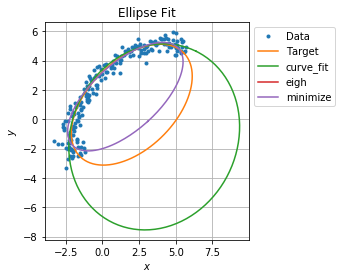

In [20]:
fig, axe = plt.subplots()
axe.plot(X[:,0], X[:,1], '.', label='Data')
axe.plot(X0[:,0], X0[:,1], label='Target')
axe.plot(Xhat1[:,0], Xhat1[:,1], label='curve_fit')
axe.plot(Xhat2[:,0], Xhat2[:,1], label='eigh')
axe.plot(Xhat3[:,0], Xhat3[:,1], label='minimize')
axe.set_title('Ellipse Fit')
axe.set_xlabel('$x$')
axe.set_ylabel('$y$')
axe.set_aspect('equal', adjustable='box')
axe.legend(bbox_to_anchor=(1,1))
axe.grid()